In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error,
    mean_squared_log_error
)
import scipy.stats as stats
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [64]:
df = pd.read_csv('../data/processed/data_processed_housing_dataset.csv')
X = df.drop(columns=['log_price', 'price'])
y = df['log_price']

In [65]:
X_train, X_test,y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [66]:
# Load the best model
best_model = joblib.load('../models/saved_models/best_model.pkl')
model_name = type(best_model).__name__
print(f"Model name: {model_name}")

Model name: Ridge


In [67]:
print(f"Test data shape: {X_test.shape}, {y_test.shape}")
print(f"Evaluating model: {model_name}")

Test data shape: (920, 14), (920,)
Evaluating model: Ridge


In [68]:
# Predict on test set (log scale)
y_pred_log = best_model.predict(X_test)

In [69]:
# Convert predictions and actuals to dollar values
y_test_dollar = np.expm1(y_test.values.ravel())
y_pred_dollar = np.expm1(y_pred_log)

In [70]:
# Log-space metrics
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)

In [71]:
# Dollar-space metrics
rmse_dollar = np.sqrt(mean_squared_error(y_test_dollar, y_pred_dollar))
r2_dollar = r2_score(y_test_dollar, y_pred_dollar)
mae_dollar = mean_absolute_error(y_test_dollar, y_pred_dollar)

In [72]:
# Percentage errors
absolute_percent_error = np.abs((y_pred_dollar - y_test_dollar) / y_test_dollar) * 100
mape = np.mean(absolute_percent_error)

/var/folders/66/qmhy_vhd6g33ljc30n_c6z4m0000gn/T/ipykernel_62411/2860745327.py:2: RuntimeWarning: divide by zero encountered in divide
  absolute_percent_error = np.abs((y_pred_dollar - y_test_dollar) / y_test_dollar) * 100


In [73]:
# RMSLE (Root Mean Squared Logarithmic Error)
rmsle = np.sqrt(mean_squared_log_error(y_test_dollar, y_pred_dollar))

In [74]:
# Create metrics summary
metrics_summary = {
    'RMSE (log)': rmse_log,
    'R2 (log)': r2_log,
    'MAE (log)': mae_log,
    'RMSE ($)': rmse_dollar,
    'R2 ($)': r2_dollar,
    'MAE ($)': mae_dollar,
    'MAPE (%)': mape,
    'RMSLE': rmsle
}

In [75]:
# Save metrics
metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv(f'../data/processed/{model_name}_test_metrics.csv', index=False)
print("\nTest Metrics:")
display(metrics_df)


Test Metrics:


,RMSE (log),R2 (log),MAE (log),RMSE ($),R2 ($),MAE ($),MAPE (%),RMSLE
0,1.379685,0.028884,0.458491,1.188135e+06,-0.384193,241353.148608,inf,1.379685


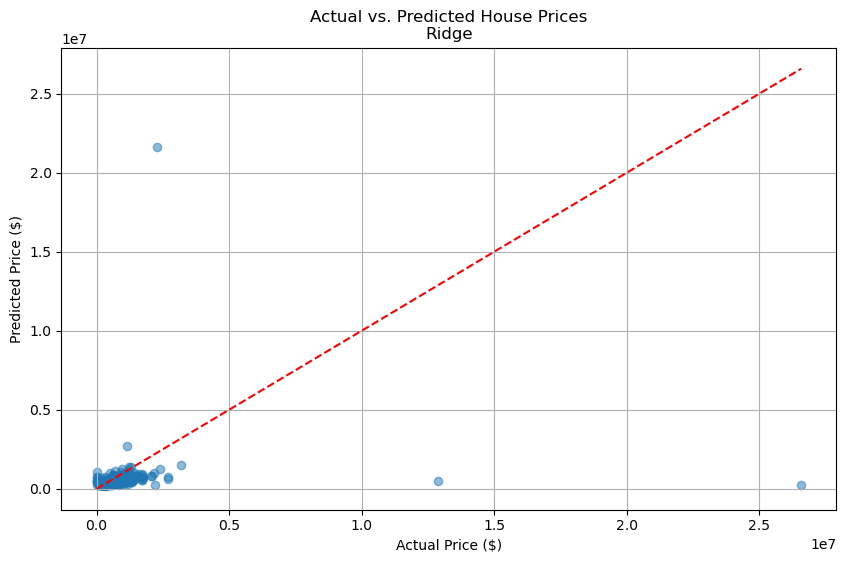

In [76]:
# 4.1 Actual vs. Predicted (dollar space)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_dollar, y_pred_dollar, alpha=0.5)
plt.plot([min(y_test_dollar), max(y_test_dollar)], 
         [min(y_test_dollar), max(y_test_dollar)], 
         color='red', linestyle='--')
plt.title(f'Actual vs. Predicted House Prices\n{model_name}')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.grid(True)
plt.savefig(f'../reports/{model_name}_actual_vs_predicted.png')
plt.show()

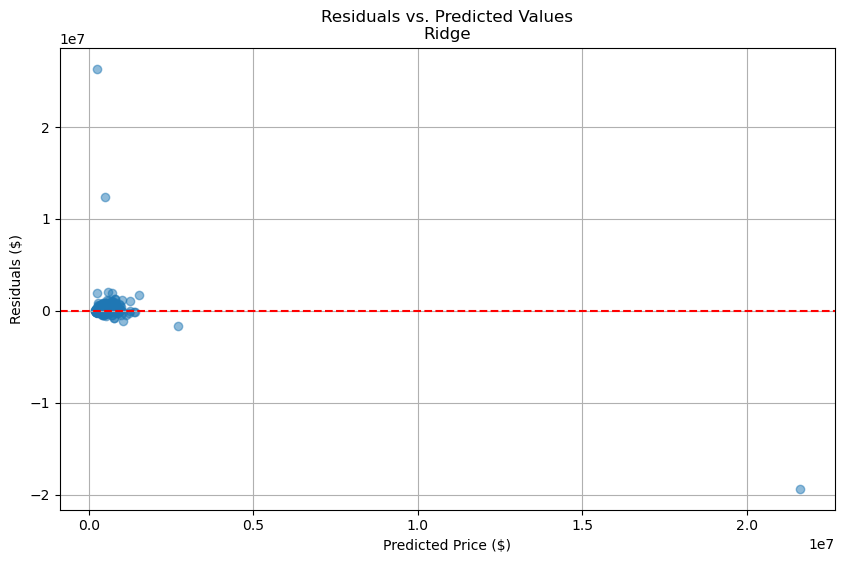

In [77]:
# 4.2 Residual Analysis
residuals_dollar = y_test_dollar - y_pred_dollar
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_dollar, residuals_dollar, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuals vs. Predicted Values\n{model_name}')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.grid(True)
plt.savefig(f'../reports/{model_name}_residuals.png')
plt.show()

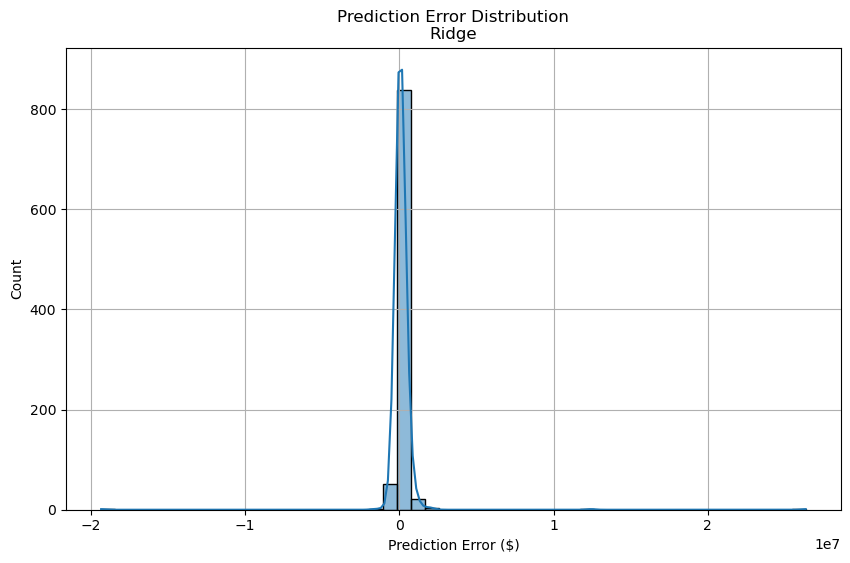

In [78]:
# Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals_dollar, kde=True, bins=50)
plt.title(f'Prediction Error Distribution\n{model_name}')
plt.xlabel('Prediction Error ($)')
plt.grid(True)
plt.savefig(f'../reports/{model_name}_error_distribution.png')
plt.show()

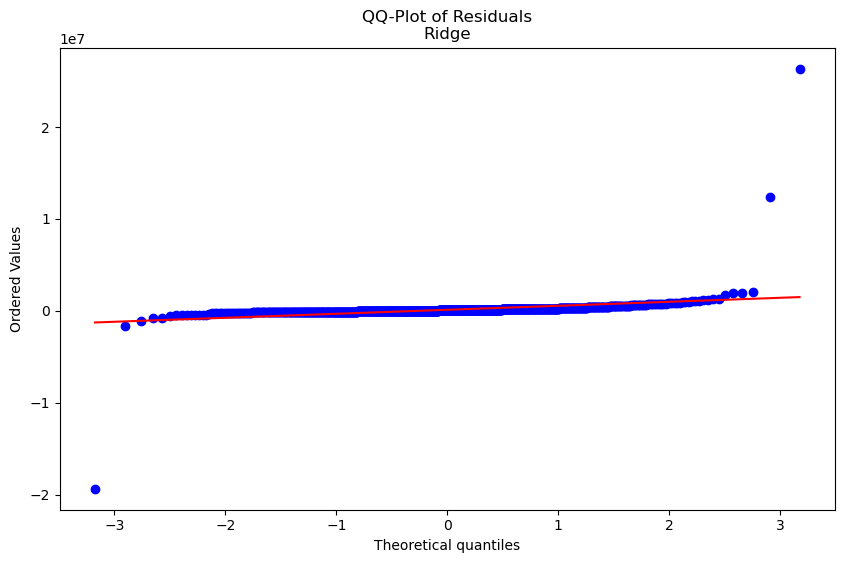

In [79]:
# QQ-Plot of Residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals_dollar, plot=plt)
plt.title(f'QQ-Plot of Residuals\n{model_name}')
plt.savefig(f'../reports/{model_name}_residuals_qqplot.png')
plt.show()

In [80]:
# Error by Price Range
price_bins = pd.qcut(y_test_dollar, 5)
error_analysis = pd.DataFrame({
    'Actual': y_test_dollar,
    'Predicted': y_pred_dollar,
    'Error': residuals_dollar,
    'Percent_Error': absolute_percent_error,
    'Price_Bin': price_bins
})

In [81]:
bin_stats = error_analysis.groupby('Price_Bin').agg({
    'Percent_Error': 'mean',
    'Error': ['mean', 'std']
}).reset_index()

bin_stats.columns = ['Price_Bin', 'MAPE', 'Mean_Error', 'Std_Error']

/var/folders/66/qmhy_vhd6g33ljc30n_c6z4m0000gn/T/ipykernel_62411/677741275.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = error_analysis.groupby('Price_Bin').agg({


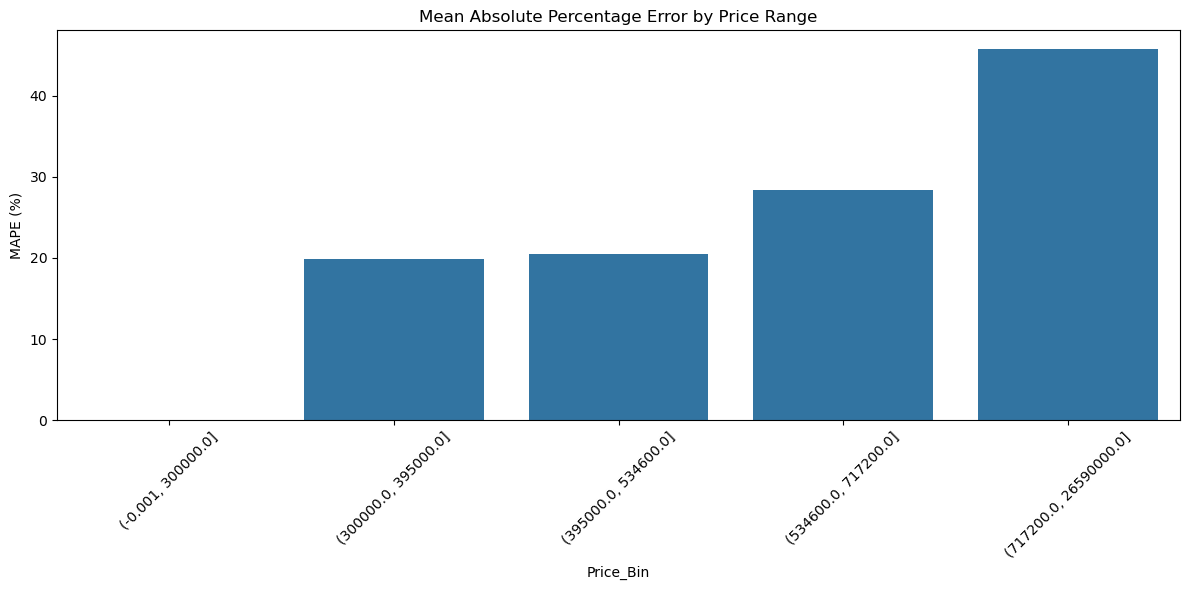

In [82]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price_Bin', y='MAPE', data=bin_stats)
plt.title('Mean Absolute Percentage Error by Price Range')
plt.xticks(rotation=45)
plt.ylabel('MAPE (%)')
plt.tight_layout()
plt.savefig(f'../reports/{model_name}_error_by_price.png')
plt.show()

In [83]:
# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.Series(
        best_model.feature_importances_,
        index=X_test.columns
    ).sort_values(ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    feature_importance.head(20).sort_values().plot(kind='barh')
    plt.title(f'Top 20 Feature Importances\n{model_name}')
    plt.tight_layout()
    plt.savefig(f'../reports/{model_name}_test_feature_importance.png')
    plt.show()

In [84]:
# Permutation Importance (for non-tree models or additional validation)
print("Calculating permutation importance...")
perm_importance = permutation_importance(
    best_model, X_test, y_test.values.ravel(), 
    n_repeats=10, random_state=42, n_jobs=-1
)

Calculating permutation importance...


In [85]:
perm_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

In [86]:
# Save importance results
perm_importance_df.to_csv(f'../data/processed/{model_name}_permutation_importance.csv', index=False)

In [87]:
# Example: Value of model in pricing strategy
average_price = np.mean(y_test_dollar)
model_value = pd.DataFrame({
    'Actual': y_test_dollar,
    'Predicted': y_pred_dollar,
    'Error': residuals_dollar
})

In [88]:
# Calculate potential revenue impact
model_value['Underpricing'] = np.where(model_value['Error'] > 0, model_value['Error'], 0)
model_value['Overpricing'] = np.where(model_value['Error'] < 0, -model_value['Error'], 0)

In [89]:
total_underpricing = model_value['Underpricing'].sum()
total_overpricing = model_value['Overpricing'].sum()

In [90]:
print(f"\nBusiness Impact Analysis:")
print(f"Total potential underpricing: ${total_underpricing:,.2f}")
print(f"Total potential overpricing: ${total_overpricing:,.2f}")
print(f"Average prediction error: ${mae_dollar:,.2f} ({mape:.2f}%)")


Business Impact Analysis:
Total potential underpricing: $169,925,491.00
Total potential overpricing: $52,119,405.72
Average prediction error: $241,353.15 (inf%)


In [91]:
# Save business impact report
with open('../reports/business_impact.txt', 'w') as f:
    f.write(f"Model: {model_name}\n")
    f.write(f"Total Test Properties: {len(X_test)}\n")
    f.write(f"Average Property Value: ${average_price:,.2f}\n")
    f.write(f"Total Underpricing Risk: ${total_underpricing:,.2f}\n")
    f.write(f"Total Overpricing Risk: ${total_overpricing:,.2f}\n")
    f.write(f"Mean Absolute Error: ${mae_dollar:,.2f}\n")
    f.write(f"Mean Absolute Percentage Error: {mape:.2f}%\n")
    f.write(f"Potential Value Capture: ${(total_underpricing + total_overpricing)/2:,.2f}")

print("\nModel evaluation complete! Reports saved.")


Model evaluation complete! Reports saved.
